In [1]:
%pylab inline
import numpy as np
import math
from sklearn.linear_model import Ridge
from tqdm import tqdm
import sys, os
import pickle
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# CUDA?
cuda = torch.cuda.is_available()

# SEED = 1
# torch.manual_seed(SEED)
# if cuda:
#     torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

num_cls = len(train.train_labels.unique())
print(num_cls)

p = train.train_data.shape[-1]
print(p)

10
28


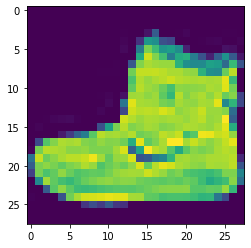

In [4]:
plt.imshow(train.train_data[0])

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = F.max_pool2d(x1, 2, 2)
        x2 = F.relu(self.conv2(x))
        x = F.max_pool2d(x2, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, x2, x1
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

In [4]:
save_path = 'cache/models'

In [36]:
EPOCHS = 15
losses = []

model.train()
best_acc = 0
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data)[0]

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])[0]
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    # save best
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save({'epoch': epoch,
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict()
                 }, '{}/FashionMNIST_epoch_{}.pth'.format(save_path, epoch))
        print('\r Best model saved.\r')
        
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Best model saved. [51456/60000 (86%)]	Loss: 0.475744
 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 0.548896	 Test Accuracy: 70.9600%
 Best model saved. [51456/60000 (86%)]	Loss: 0.358773
 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 0.310663	 Test Accuracy: 78.7800%
 Best model saved. [51456/60000 (86%)]	Loss: 0.359929
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 0.254411	 Test Accuracy: 79.4400%
 Best model saved. [51456/60000 (86%)]	Loss: 0.283815
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 0.365767	 Test Accuracy: 82.2500%
 Best model saved. [51456/60000 (86%)]	Loss: 0.295290
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 0.393457	 Test Accuracy: 84.0500%
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 0.214282	 Test Accuracy: 81.6900%
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 0.261961	 Test Accuracy: 81.1200%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 0.209926	 Test Accuracy: 83.1300%
 Best model saved. [51456/60000 (86%)]	Loss: 0.249861
 Train Epoch: 9/15 [60000/60000 (100

In [5]:
# Load and use the best model
bst_mdl = save_path+'/FashionMNIST_epoch_8.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### White noise

In [10]:
# generate random pattern, recording conv1 and conv2 neuron responses
iter_ = 1000
all_size = 10000

model.eval()
noise = {}
stats = {}
for cls in range(num_cls):
    noise[cls] = []
    stats[cls] = 0
with tqdm(total=iter_, file=sys.stdout) as pbar:
    for i in range(iter_):
        z = torch.rand(all_size, p, p)
        if cuda:
            z = z.cuda()
        with torch.no_grad():
            pred = model(z[:,None,...])[0].max(1)[1]
        
        for cls in range(num_cls):
            noise[cls].append(z[pred == cls].cpu())
            stats[cls] += (pred == cls).sum()
        pbar.update(1)

for cls in range(num_cls):
    noise[cls] = torch.cat(noise[cls])

100%|██████████| 1000/1000 [01:10<00:00, 14.22it/s]


In [11]:
stats

{0: tensor(560, device='cuda:0'),
 1: tensor(935, device='cuda:0'),
 2: tensor(13249, device='cuda:0'),
 3: tensor(16, device='cuda:0'),
 4: tensor(11, device='cuda:0'),
 5: tensor(11, device='cuda:0'),
 6: tensor(454083, device='cuda:0'),
 7: tensor(0, device='cuda:0'),
 8: tensor(9531116, device='cuda:0'),
 9: tensor(19, device='cuda:0')}

/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked eleme

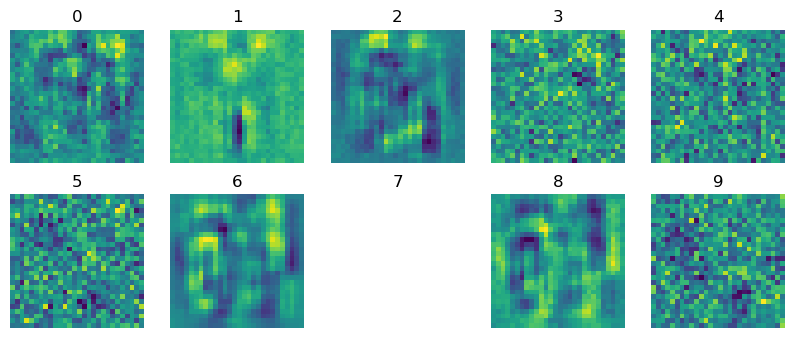

In [12]:
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for cls in range(num_cls):
    a = noise[cls].mean(0)
    a = (a-a.min())/(a.max()-a.min())
    plt.subplot(2, 5, cls+1)
    plt.axis('off')
    plt.title(str(cls))
    plt.imshow(a)

### Gabor white noise

In [15]:
# generate gabor filters
n_theta = 4
n_psi = 2
Theta = [i * np.pi /n_theta for i in range(n_theta)]
Psi = [i * np.pi /n_psi for i in range(n_psi)]
ksize = [3, 7, 15]
# ksize = [5, 15, 29]
rep_ct = [int(ceil(p/i)) for i in ksize]
print('\n', Theta, '\n', Psi, '\n', rep_ct)


g_kernels = []
for i in range(len(rep_ct)):
    for _theta in Theta:
        for _psi in Psi:
            for rep in range(rep_ct[i]**2):
                k = ksize[i]
                g_kernel = cv2.getGaborKernel((k, k), k/7.0, _theta, k/2.0,
                                              0.5, _psi, ktype=cv2.CV_32F) 
                g_kernel = (g_kernel - g_kernel.min())/(g_kernel.max()-g_kernel.min())
                g_kernels.append(g_kernel)
                
print(len(g_kernels))

img_kernels = []
ctr = 0
for idx in range(len(rep_ct)):
    cur_ct = rep_ct[idx]
    k = ksize[idx]
    print(ctr, cur_ct, k)
    for _ in range(n_theta * n_psi):
        with tqdm(total=cur_ct**2, file=sys.stdout) as pbar:
            for i in range(cur_ct):
                for j in range(cur_ct):
#                     import pdb;pdb.set_trace()
                    tmp = np.zeros((p, p))
                    size_i = min(k*(i+1), p) - k*i
                    size_j = min(k*(j+1), p) - k*j
                    tmp[k*i: k*i + size_i, k*j: k*j + size_j] = g_kernels[ctr][:size_i, :size_j]
                    img_kernels.append(tmp)
                    ctr += 1
                    pbar.update(1)
            
        


 [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345] 
 [0.0, 1.5707963267948966] 
 [10, 4, 2]
960
0 10 3
100%|██████████| 100/100 [00:00<00:00, 96332.20it/s]
800 4 7
100%|██████████| 16/16 [00:00<00:00, 21210.13it/s]
928 2 15
100%|██████████| 4/4 [00:00<00:00, 8952.62it/s]


(784, 960) (784, 60000)
(60000, 960)


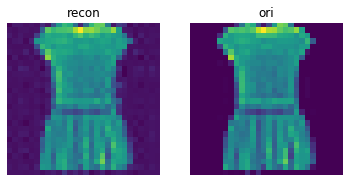

1342.1717899606267


In [29]:
# ridge regression to get weights
from sklearn.linear_model import Ridge

all_wts = []
num_sample = len(train.train_data)

X = np.stack(img_kernels, -1)
X = X.reshape(-1, X.shape[-1])

y = train.train_data[:num_sample].permute(1, 2, 0).numpy()
y = y.reshape(-1, y.shape[-1])

print(X.shape, y.shape)

clf = Ridge(alpha=0.1)
clf.fit(X, y)

wts = clf.coef_
print(wts.shape)
# import pdb; pdb.set_trace()

img_id = 3
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('recon')
plt.imshow(wts.dot(X.T)[img_id].reshape(p, p))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('ori')
plt.imshow(y[:, img_id].reshape(p, p))
plt.show()
print(np.linalg.norm(y[:, img_id] - wts.dot(X.T)[img_id]))

np.save('cache/fashion_gabor_wts.npy', wts)

In [17]:
all_wts = np.load('cache/fashion_gabor_wts.npy')
from sklearn.decomposition import PCA
num_pc = 250
pca = PCA(n_components=num_pc)
principalComponents = pca.fit_transform(all_wts)
print(pca.explained_variance_ratio_.sum())
print(principalComponents.shape)
print(pca.components_.shape)

0.9008363526198393
(60000, 250)
(250, 960)


In [18]:
num_noise = 1000000
noise_wts = np.random.rand(num_noise, num_pc)

with tqdm(total=num_pc, file=sys.stdout) as pbar:
    for i in range(num_pc):
        cur_max = principalComponents[:, i].max()
        cur_min = principalComponents[:, i].min()
        cur_wts = noise_wts[:, i]
        cur_wts = (cur_wts - cur_wts.min())/(cur_wts.max() - cur_wts.min())
        noise_wts[:, i] = cur_wts * (cur_max - cur_min) + cur_min
    
        pbar.update(1)

noise_gabor_wts = noise_wts.dot(pca.components_)
noise_gabor_wts.shape

100%|██████████| 250/250 [00:14<00:00, 17.10it/s]


(1000000, 960)

In [19]:
X = np.stack(img_kernels)
X = X.reshape(X.shape[0], -1)
noise = noise_gabor_wts.dot(X).reshape(num_noise, p, p)

with tqdm(total=num_noise, file=sys.stdout) as pbar:
    for i in range(num_noise):
        noise[i] = (noise[i] - noise[i].min())/(noise[i].max() - noise[i].min())
        pbar.update(1)

print(noise.shape)
np.save('cache/fashion_gabor_noise.npy', noise)

100%|██████████| 1000000/1000000 [00:10<00:00, 91549.84it/s]
(1000000, 28, 28)


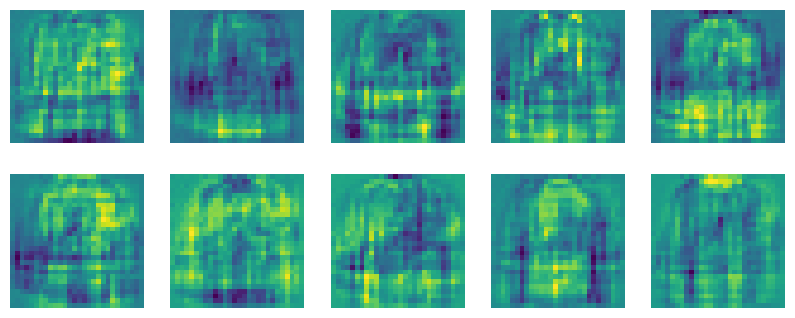

In [6]:
# mnist noise examples
noise = np.load('cache/fashion_gabor_noise.npy')
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(10):
    a = noise[i]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(a)
plt.show()

In [7]:
noise = np.load('cache/fashion_gabor_noise.npy')
num_noise = noise.shape[0]
num_cls = 10

noise_data = {}
for cls in range(num_cls):
    noise_data[cls] = []

batch_size = 10000
model.eval()
with tqdm(total=num_noise//batch_size, file=sys.stdout) as pbar:
    for i in range(num_noise//batch_size):
        data = torch.from_numpy(noise[i * batch_size: (i+1) * batch_size]).float()
        if cuda:
            data = data.cuda()
        with torch.no_grad():
            pred = model(data[:,None,...])[0].max(1)[1]
            for cls in range(num_cls):
                noise_data[cls].append(data[pred==cls].cpu())
        pbar.update(1)

for cls in range(num_cls):
    noise_data[cls] = torch.cat(noise_data[cls])
    print(cls, ':', noise_data[cls].shape[0])

100%|██████████| 100/100 [00:02<00:00, 38.42it/s]
0 : 38344
1 : 31501
2 : 216121
3 : 10604
4 : 21653
5 : 3
6 : 183858
7 : 203
8 : 484047
9 : 13666


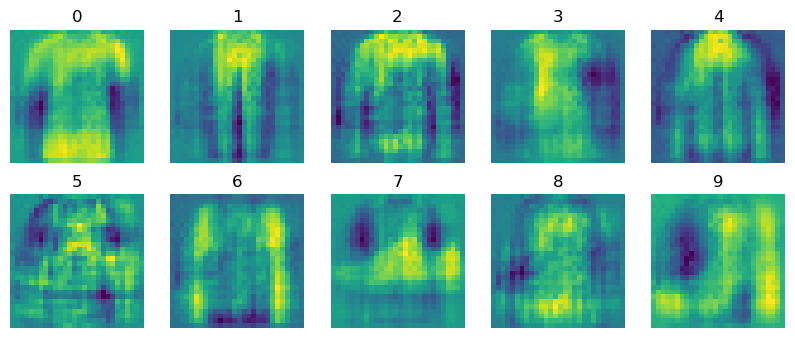

In [20]:
noise_avg = []
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for cls in range(num_cls):
    a = noise_data[cls].mean(0).numpy()
#     a = torch.sqrt((noise_data[cls]**2).mean(0)).numpy()
    a = (a - a.min()) / (a.max() - a.min())
    noise_avg.append(a)
    plt.subplot(2, 5, cls+1)
    plt.axis('off')
    plt.title(str(cls))
    plt.imshow(a)
plt.show()

In [9]:
def plot_confusion_matrix( y_pred, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    import sklearn
    from sklearn import metrics
#     cf = sklearn.metrics.confusion_matrix(pred.numpy(), gt.numpy())  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
  
    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_pred, y_true)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] )
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')
#     print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]+1)-0.5,
           yticks=np.arange(cm.shape[0]+1)-0.5,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

(10, 784)
Accuracy:  0.41208333333333336


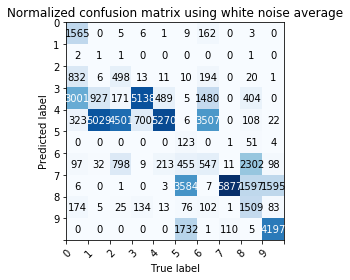

In [22]:
##### Dot product NN #####

avg_vec = np.stack(noise_avg).reshape(num_cls, -1)

print(avg_vec.shape)

pred = []
gt = []
templates = torch.from_numpy(avg_vec).permute(1, 0)
templates = templates / torch.norm(templates, p=2, dim=0)

for batch_idx, (data, target) in enumerate(train_loader):
#     data = data.mean(1) # for greyscale
    x = data.view(data.shape[0], -1)
    x = x / torch.cat([torch.norm(x, p=2, dim=1).view(-1,1)] * x.shape[1], 1)
    pred.append(torch.mm(x, templates).max(1)[1])
    gt.append(target)
pred = torch.cat(pred)
gt = torch.cat(gt)

acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=False,  title='Normalized confusion matrix using white noise average')

In [32]:
noise_avg.shape

AttributeError: 'list' object has no attribute 'shape'